In [2]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
sys.path.insert(0,"/home/claudio/postdoc/Castle/")
from castle import ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation, LPEnsamble, LinearPotential
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils

def split_dataset(N, training_percentage, seed=20):
    np.random.seed(seed)
    ids = list(range(N))
    np.random.shuffle(ids)
    return ids[:int(training_percentage*N)], ids[int(training_percentage*N):]

%load_ext autoreload
%autoreload 2

In [3]:
# Load xyz data
input_file =  "/home/claudio/postdoc/data/water/train_all.xyz"
frames = read(input_file, index = ':')
    
energy_name = 'energy'
force_name = 'force'

In [4]:
# Create training and validation set
tr_ind, val_ind = split_dataset(len(frames), 0.8)
tr_frames = [frames[s] for s in tr_ind]
val_frames = [frames[s] for s in val_ind]
e_t, f_t = get_forces_and_energies(tr_frames, energy_name = energy_name, force_name = force_name)
e_val, f_val = get_forces_and_energies(val_frames, energy_name = energy_name, force_name = force_name)
nat_val = get_nat(val_frames)

N = 6               # Body order
maxdeg = 8          # Maximum degree of angular and radial expansion
rcut = 6.0          # Radial Cutoff
r0 = 0.2            # Lowest radius for basis
reg = 1e-8          # Ridge regularizer
species = [1, 8]    # Atomic number of species present

representation = AceGlobalRepresentation(N, maxdeg, rcut, species, r0, reg, 
                                         energy_name=energy_name, force_name=force_name)

In [5]:
# features = representation.transform(features)
# dump(input_file[:-4] + "_features.xz", features)

In [6]:
features = load(input_file[:-4] + "_features.xz")

In [7]:
noise = 1e-6

# get the subset of features for training
tr_features = features.get_subset(tr_ind)


# get the subset of features for training
tr_features = features.get_subset(tr_ind)
val_features = features.get_subset(val_ind)

CPU times: user 10.5 s, sys: 536 ms, total: 11 s
Wall time: 10.4 s
MAE=0.018 RMSE=0.169 SUP=0.041 R2=0.107
MAE=0.319 RMSE=32.114 SUP=7328.943 R2=0.002


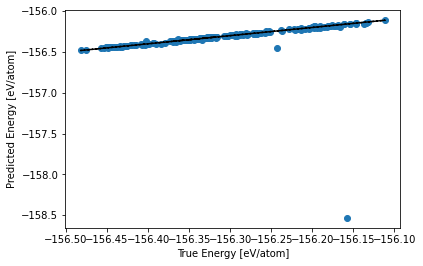

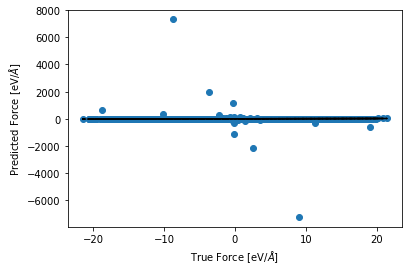

In [9]:
# Model parameters
n_clusters = 10
clustering_type = 'kmeans'
baseline_perc = 0
noise = 1e-6

# train the model
model_ens =  LPEnsamble(n_clusters=n_clusters, clustering_type=clustering_type, baseline_percentile=baseline_perc)
model_ens.fit_from_features(tr_features, e_t, f_t, noise)
# evaluate its performances
%time ep, fp = model_ens.predict_from_features(val_features)
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [10]:
# evaluate its performances
nat_tr = get_nat(tr_frames)

%time ep, fp = model_ens.predict_from_features(val_features)

print_score(ep/nat_tr, e_t/nat_tr)
print_score(fp.flatten(), f_t.flatten())

plt.scatter(e_t/nat_tr, ep/nat_tr)
plt.plot(e_t/nat_tr, e_t/nat_tr, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(np.ravel(f_t), np.ravel(fp))
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.tight_layout()
# plt.savefig("../../plots/Si_linear.png", dpi=400)

CPU times: user 10.7 s, sys: 8.03 ms, total: 10.7 s
Wall time: 10.7 s


ValueError: operands could not be broadcast together with shapes (200,) (800,) 